# Fig.6 Robustness of network structure

In [ ]:
import pandas as pd
import os
import glob
from plot_helpers import (
    get_agg_metric,
    patch_violinplot,
    point_violinplot,
    bonferroni_correction,
    get_corrected_p,
    get_annotation,
    add_annotation,
    BLUEPALETTE,
)

# Read prevalence data

In [10]:
# empirical = empirical[empirical["illegal_prob"] == 0.01]
combined = pd.concat([synthetic, empirical], ignore_index=True)

In [11]:
combined.groupby("illegal_prob")["fpath"].count()

illegal_prob
0.01    837
Name: fpath, dtype: int64

In [13]:
# combined["base_name"] = combined["fpath"].apply(lambda x: os.path.basename(x))
# combined["illegal_prob"] = combined["base_name"].apply(extract_float)
print("illegal prob values:", combined["illegal_prob"].unique())
print("len combined data: ", len(combined))
data = combined[~combined["unique_illegal_frac"].isna()]
print("len combined data (after removing nans): ", len(data))

illegal prob values: [0.01]
len combined data:  837
len combined data (after removing nans):  837


In [14]:
data["half_life"] = data.apply(
    lambda row: -1 if "b_" in row["base_name"] else row["moderation_half_life"], axis=1
)
retain_cols = [
    "network",
    "illegal_frac",
    "unique_illegal_frac",
    "illegal_count",
    "unique_illegal_count",
    "illegal_prob",
    "half_life",
]
data = data[retain_cols]
data.head()

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life
0,synthetic,0.018729,0.011701,2811,13,0.01,-1.0
1,synthetic,0.007069,0.005464,1061,6,0.01,2.0
2,synthetic,0.006290,0.007853,944,9,0.01,8.0
3,synthetic,0.009594,0.008681,1440,10,0.01,-1.0
4,synthetic,0.008208,0.010998,1230,13,0.01,2.0


# Calculate percentage change: 
pct_change = metric-baseline_mean / (baseline_mean)

Merge scatter data with avg baseline

In [18]:
# create a new column since illegal_prob is used as a dummy column
# data["illegal_content_probability"] = data["illegal_prob"]
baseline = data[data.half_life == -1]
# baseline['network_type']=  baseline['network']
baseline = get_agg_metric(
    baseline,
    group_key=["network", "illegal_prob"],
    new_col_prefix="baseline",
    metrics=[
        "illegal_frac",
        "unique_illegal_frac",
    ],
    retain_keys=["half_life"],
)

/geode2/home/u015/baotruon/BigRed200/carisma/experiments/20250210_all_experiments/plot_helpers.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{metric}_std"] = df[metric]


In [19]:
baseline

,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,network,baseline_no_observations,half_life
0,0.009655,0.010314,0.004352,0.001338,empirical,0.01,-1.0
1,0.011183,0.011929,0.004376,0.002688,synthetic,0.01,-1.0


## Get pct change

In [20]:
res = data[data.half_life != -1]
baseline = baseline.drop(columns=["half_life"])
baseline = baseline.dropna(subset="baseline_illegal_frac_std")
results = res.merge(baseline, on="network", how="left")

In [21]:
results.head()

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations
0,synthetic,0.007069,0.005464,1061,6,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01
1,synthetic,0.006290,0.007853,944,9,0.01,8.0,0.011183,0.011929,0.004376,0.002688,0.01
2,synthetic,0.008208,0.010998,1230,13,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01
3,synthetic,0.010707,0.012585,1607,13,0.01,8.0,0.011183,0.011929,0.004376,0.002688,0.01
4,synthetic,0.006518,0.006082,978,7,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01


In [22]:
results = results[~results.unique_illegal_frac.isna()]

In [23]:
metric = "unique_illegal_frac"
results["pct_change"] = (
    (results[f"baseline_{metric}_mean"] - results[metric])
    / results[f"baseline_{metric}_mean"]
    * 100
)

In [24]:
results

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
0,synthetic,0.007069,0.005464,1061,6,0.01,2.0000,0.011183,0.011929,0.004376,0.002688,0.01,54.189959
1,synthetic,0.006290,0.007853,944,9,0.01,8.0000,0.011183,0.011929,0.004376,0.002688,0.01,34.163056
2,synthetic,0.008208,0.010998,1230,13,0.01,2.0000,0.011183,0.011929,0.004376,0.002688,0.01,7.798572
3,synthetic,0.010707,0.012585,1607,13,0.01,8.0000,0.011183,0.011929,0.004376,0.002688,0.01,-5.500569
4,synthetic,0.006518,0.006082,978,7,0.01,2.0000,0.011183,0.011929,0.004376,0.002688,0.01,49.015931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,empirical,0.008325,0.010069,1248,54,0.01,128.0000,0.009655,0.010314,0.004352,0.001338,0.01,2.372723
773,empirical,0.009322,0.008220,1397,44,0.01,8.0000,0.009655,0.010314,0.004352,0.001338,0.01,20.303244
774,empirical,0.007542,0.007018,1128,39,0.01,8.0000,0.009655,0.010314,0.004352,0.001338,0.01,31.952931
775,empirical,0.003617,0.003217,537,17,0.01,1.0000,0.009655,0.010314,0.004352,0.001338,0.01,68.805982


# Statistical significance: pct change 

## Filter tau=2 (remove outliers)

In [26]:
from scipy.stats import mannwhitneyu

stat_res = []
probs = sorted(results.network.dropna().unique())
pairs = [
    (probs[i], probs[j]) for i in range(len(probs)) for j in range(i + 1, len(probs))
]
pairs

[('empirical', 'synthetic')]

In [ ]:
focal = results[results.half_life == 2]
focal = focal[focal["pct_change"] > 0]
em = focal[focal.network == "empirical"].sample(10, random_state=15)
syn = focal[focal.network == "synthetic"]
focal = pd.concat([em, syn], ignore_index=True)
tau2_res = focal

In [30]:
stat_res = []
for pair in pairs:
    # randomly choose 10 records of empirical
    pop1 = focal[focal.network == pair[0]]["pct_change"]
    pop2 = focal[focal.network == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [32]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(empirical, synthetic)",78.0,0.114466,0.114466


## Filter tau=8

In [36]:
from scipy.stats import mannwhitneyu

stat_res = []
probs = sorted(results.network.dropna().unique())
pairs = [
    (probs[i], probs[j]) for i in range(len(probs)) for j in range(i + 1, len(probs))
]
pairs

[('empirical', 'synthetic')]

In [ ]:
focal = results[results.half_life == 8]
focal = focal[focal["pct_change"] > 0]  # Remove outlier
em = focal[focal.network == "empirical"].sample(10, random_state=15)
syn = focal[focal.network == "synthetic"]
focal = pd.concat([em, syn], ignore_index=True)
tau8_res = focal

In [39]:
stat_res = []
for pair in pairs:
    # randomly choose 10 records of empirical
    pop1 = focal[focal.network == pair[0]]["pct_change"]
    pop2 = focal[focal.network == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [41]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(empirical, synthetic)",33.0,0.217563,0.217563


# Plot in panel

In [44]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

plt.style.use("stylesheet.mplstyle")
PLOT_DIR = "plots_check"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
fpath = os.path.join(PLOT_DIR, f"pct_change_syntheticnet")

Probs:  ['empirical', 'synthetic']
p-values:                      pair     U         p  corrected_p
0  (empirical, synthetic)  78.0  0.114466     0.114466
Significant pairs (p<0.001):  []
p-values:                      pair     U         p  corrected_p
0  (empirical, synthetic)  33.0  0.217563     0.217563
Significant pairs (p<0.001):  []


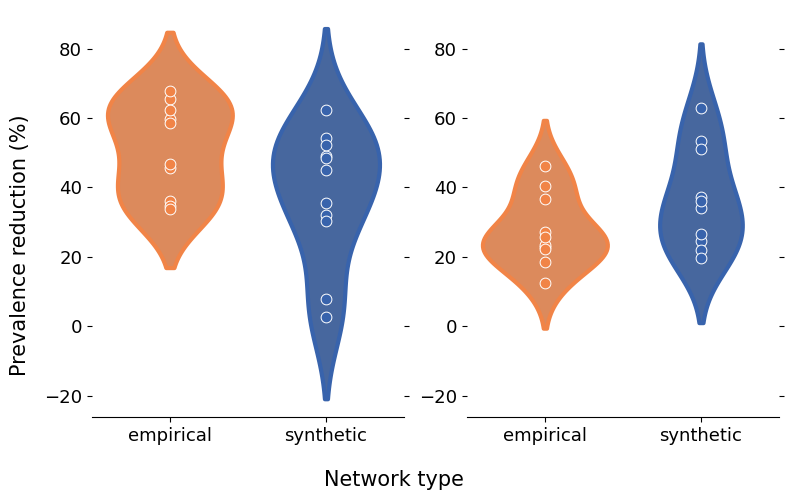

In [46]:
sig_level = 0.001
plot_dfs = [tau2_res, tau8_res]
y_label = "Prevalence reduction (%)"
x_label = "Network type"
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

print("Probs: ", probs)
for idx, plot_data in enumerate(plot_dfs):
    # print(f"** Plot {y_labels[idx]} **")
    ax = axs[idx]
    # Create the violin plot
    violin = sns.violinplot(
        ax=ax,
        data=plot_data,
        x="network",
        y="pct_change",
        order=probs,
        inner="point",
        palette=BLUEPALETTE,
    )
    violin.set_xlabel("")
    violin.set_ylabel("")

    patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
    point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=60, linewidth=0.7)
    ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
    sns.despine(top=True, left=True, bottom=False)

    ## TEST SIGNIFICANCE
    stats, significant_pairs = get_corrected_p(
        plot_data, focal_col="network", sig_level=sig_level
    )
    significant_pairs = [
        i for i in significant_pairs if i[0] in probs and i[1] in probs
    ]
    # Add annotations for significant pairs
    y_max = plot_data["pct_change"].max()
    for x1, x2 in significant_pairs:
        stat, p = stats[stats["pair"] == (x1, x2)][["U", "corrected_p"]].values[0]
        if p < sig_level:
            y = y_max + 5  # Adjust the y position for the annotation
            add_annotation(ax, probs.index(x1), probs.index(x2), y, get_annotation(p))
            print(f"Pair ( {x1}, {x2} ): p-value: {p:.2e}")
            y_max += 10  # Increment y_max for the next annotation

    # ax.set_ylim(0, 100)
fig.supylabel(y_label, fontsize=15)
fig.supxlabel(x_label, fontsize=15)
# Saving
plt.tight_layout()

if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()